In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('covtype.csv')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [7]:
# Split features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type'] - 1  # subtract 1 to make the target 0-based

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Initialize and train XGBoost model
model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=8,  # number of forest cover types
    random_state=42
)

In [10]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [11]:
# Make predictions
y_pred = model.predict(X_test)

In [12]:
# For reporting, add 1 back to the classes to maintain original labels
print("Classification Report:")
print(classification_report(y_test + 1, y_pred + 1))

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.79      0.80     42557
           2       0.82      0.86      0.84     56500
           3       0.81      0.88      0.84      7121
           4       0.87      0.81      0.84       526
           5       0.87      0.32      0.47      1995
           6       0.77      0.57      0.66      3489
           7       0.90      0.82      0.86      4015

    accuracy                           0.81    116203
   macro avg       0.83      0.72      0.76    116203
weighted avg       0.82      0.81      0.81    116203


In [13]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

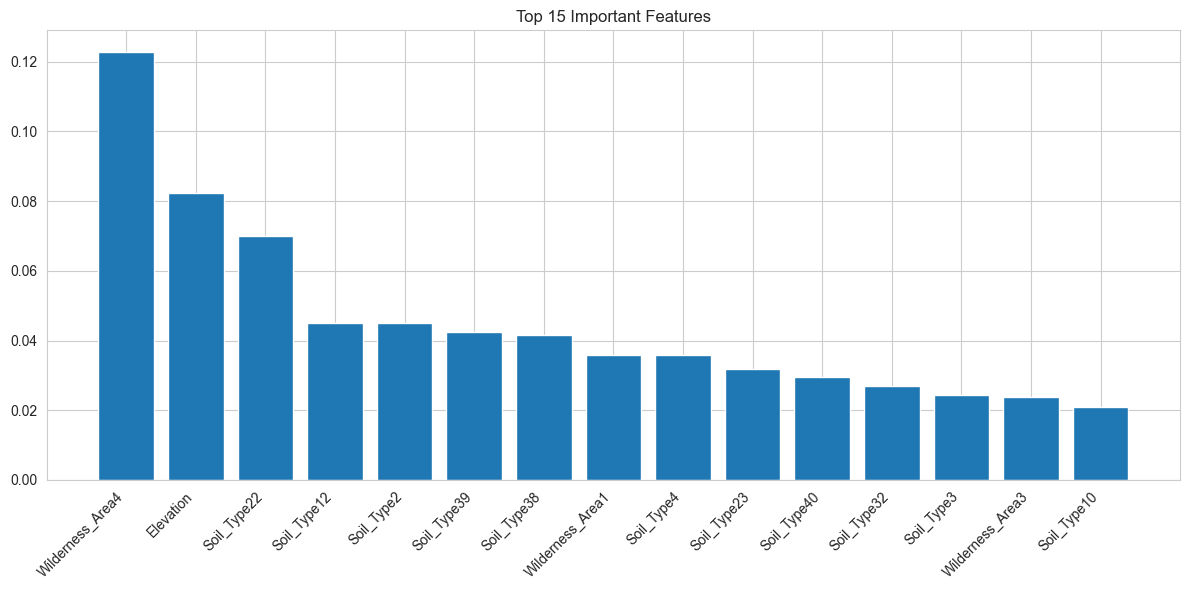

In [14]:
# Plot top 15 important features
plt.figure(figsize=(12, 6))
plt.bar(importance_df['feature'][:15], importance_df['importance'][:15])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Important Features')
plt.tight_layout()
plt.show()

In [15]:
# Print top 10 important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))


Top 10 Most Important Features:
             feature  importance
13  Wilderness_Area4    0.122822
0          Elevation    0.082431
35       Soil_Type22    0.069946
25       Soil_Type12    0.045043
15        Soil_Type2    0.044947
52       Soil_Type39    0.042557
51       Soil_Type38    0.041467
10  Wilderness_Area1    0.035971
17        Soil_Type4    0.035870
36       Soil_Type23    0.031909


In [16]:
# Calculate and print confusion matrix with original labels
cm = confusion_matrix(y_test + 1, y_pred + 1)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[33478  8719     3     0    12     6   339]
 [ 7201 48655   307     1    83   232    21]
 [    0   507  6233    41     1   339     0]
 [    0     0    87   428     0    11     0]
 [   11  1308    35     0   636     5     0]
 [    7   452  1010    24     1  1995     0]
 [  722    20     0     0     0     0  3273]]


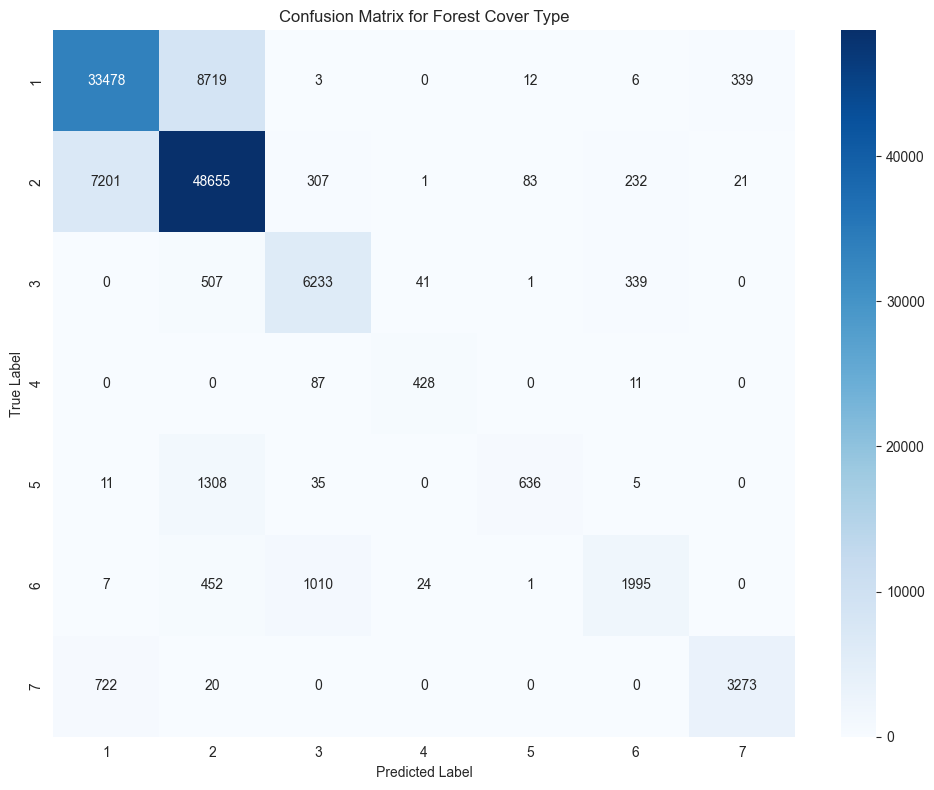

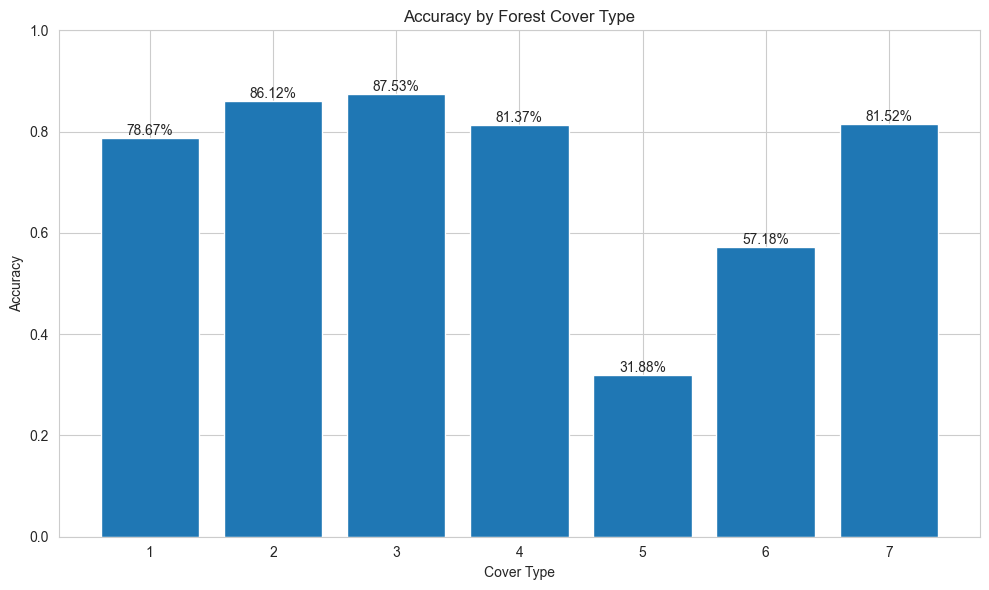

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels
plt.title('Confusion Matrix for Forest Cover Type')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add class labels
plt.xticks(np.arange(7) + 0.5, range(1, 8))
plt.yticks(np.arange(7) + 0.5, range(1, 8))

plt.tight_layout()
plt.show()

# Calculate accuracy for each class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(1, 8), class_accuracy)
plt.title('Accuracy by Forest Cover Type')
plt.xlabel('Cover Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add percentage labels on top of bars
for i, acc in enumerate(class_accuracy):
    plt.text(i+1, acc, f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()